In [1]:
#패키지 불러오기 및 각종 설치 & 폰트 설정 한방에 
import matplotlib
%matplotlib inline
matplotlib.rcParams['axes.unicode_minus'] = False

# !pip install catboost
# !pip install pycaret
from tqdm.notebook import tqdm
from pycaret.regression import *

import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from glob import glob
warnings.filterwarnings("ignore")

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

In [2]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f, ax = plt.subplots(figsize=(10, desc.shape[0] * 0.75))

    sns.heatmap(
        desc,
        annot=True,
        cmap="Blues",
        fmt=".2f",
        ax=ax,
        linecolor="white",
        linewidths=1.3,
        cbar=False,
        annot_kws={"size": 12},
    )
    plt.xticks(size=14)
    plt.yticks(size=12, rotation=0)
    plt.title("Descriptive Statistics", size=14)
    plt.show()

In [3]:
# 함수 정의: 두 데이터 테이블과 특정 컬럼을 집어 넣으면 value를 비교하여 출력하는 함수
def check_train_test_column_values(train, test, column):
    print("🐸 {} Column에 대한 train_test_values_check 입니다=======================".format(column))
    # Train/Test set의 입력 칼럼의 value를 set으로 받아줍니다.
    train_colset = set(train[column])
    test_colset  = set(test[column])

    # Train/Test-set 고유한 value의 개수를 구함.
    print(f"\nTrain-set에 있는 고유한 value 개수 : {len(train_colset)}")
    print(f"Test-set에 있는 고유한 value 개수 : {len(test_colset)}\n")

    # Train/Test-set 모두에 포함되어있는 value를 구함.
    print('='* 80)
    common_colset = train_colset.intersection(test_colset)
    print(f"Train/Test-set에 공통으로 포함되어 있는 value 개수 : {len(common_colset)}")
    if len(common_colset) > 100: # value가 너무 많으면 어차피 보기 힘드므로 출력을 pass 합니다
        pass
    else:
        try: # int나 float은 sorted가 먹지 않기 때문에 try except로 넣어줍니다.
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {sorted(common_colset)}")
        except:
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {(common_colset)}")

    # Train-set에만 있는 value를 구함.
    train_only_colset = train_colset.difference(test_colset)
    print(f"\nTrain-set에만 있는 value는 총 {len(train_only_colset)} 개 입니다.")
    if len(train_only_colset) > 100:
        pass
    else:
        try:
            print(f"Train-set에만 있는 value는 : {sorted(train_only_colset)}")
        except:
            print(f"Train-set에만 있는 value는 : {(train_only_colset)}")

    # Test-set에만 있는 value를 구함.
    test_only_colset = test_colset.difference(train_colset)
    print(f"Test-set에만 있는 value는 총 {len(test_only_colset)} 개 입니다.")
    if len(test_only_colset) > 100:
        pass
    else:
        try:
            print(f"Test-set에만 있는 value는 : {sorted(test_only_colset)}")
        except:
            print(f"Test-set에만 있는 value는 : {(test_only_colset)}")
    print(" ")

In [4]:
file_path = glob('data/*.csv')

In [5]:
file_path

['data\\age_gender_info.csv',
 'data\\sample_submission.csv',
 'data\\test.csv',
 'data\\train.csv']

In [6]:
df_info = pd.read_csv(file_path[0])
df_train = pd.read_csv(file_path[3])
df_test = pd.read_csv(file_path[2])

In [7]:
# Train/test data 불러오기 및 오류 데이터 제거
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
df_train = df_train[~df_train['단지코드'].isin(train_error)].reset_index(drop=True)
test_error = ['C2675', 'C2335', 'C1327']
df_test = df_test[~df_test['단지코드'].isin(test_error)].reset_index(drop=True)
print(f'Train Set: {df_train.shape} | Test Set: {df_test.shape}')

Train Set: (2869, 15) | Test Set: (1008, 14)


In [8]:
df_train.shape, df_test.shape, df_info.shape, 

((2869, 15), (1008, 14), (16, 23))

In [9]:
df_test.shape

(1008, 14)

# EDA
#### [Dacon 코드공유 게시물 참고](https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent) 

In [10]:
df_train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [11]:
df_test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [12]:
df_train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

df_test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

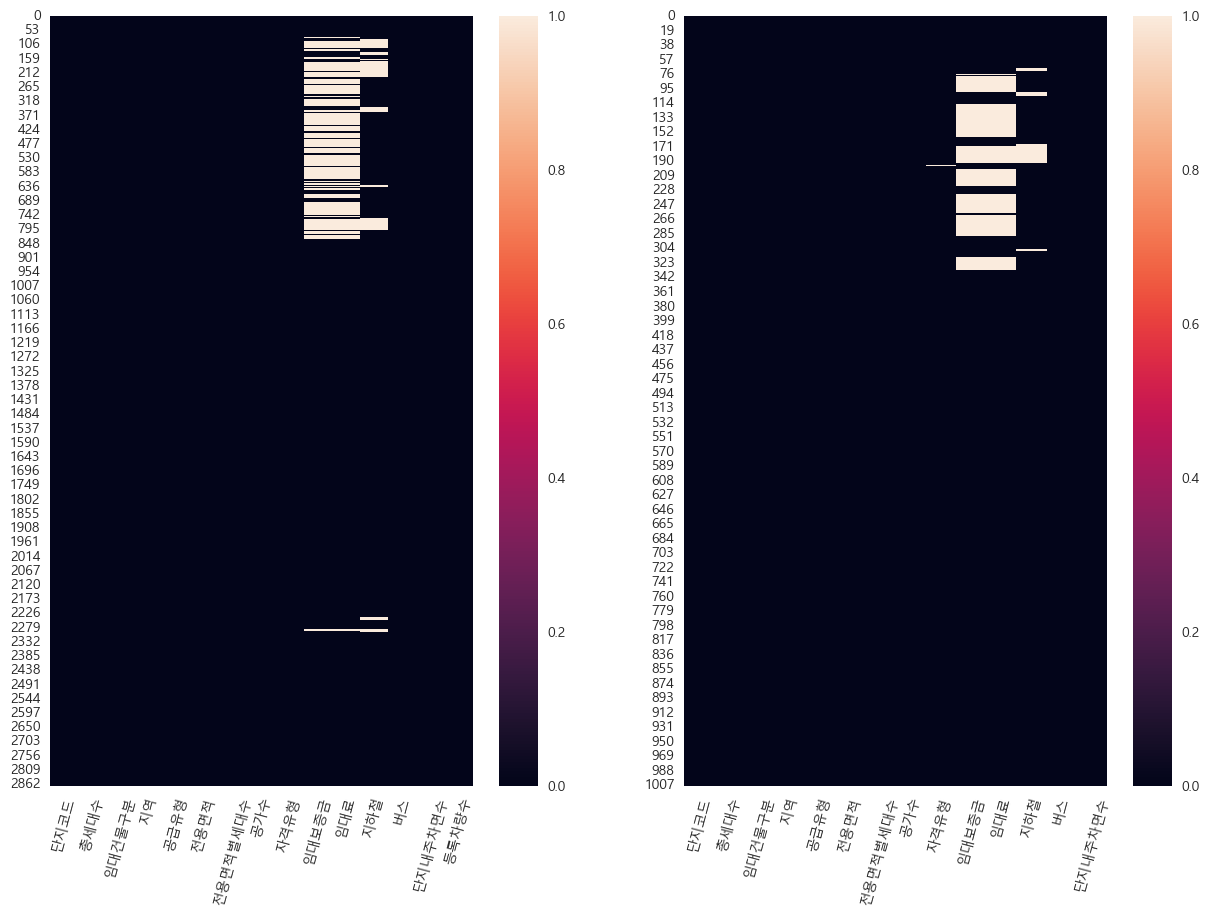

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
sns.heatmap(df_train.isnull(), ax=ax[0]).set_xticklabels(df_train.isnull(), rotation=75);
sns.heatmap(df_test.isnull(), ax=ax[1]).set_xticklabels(df_test.isnull(), rotation=75);


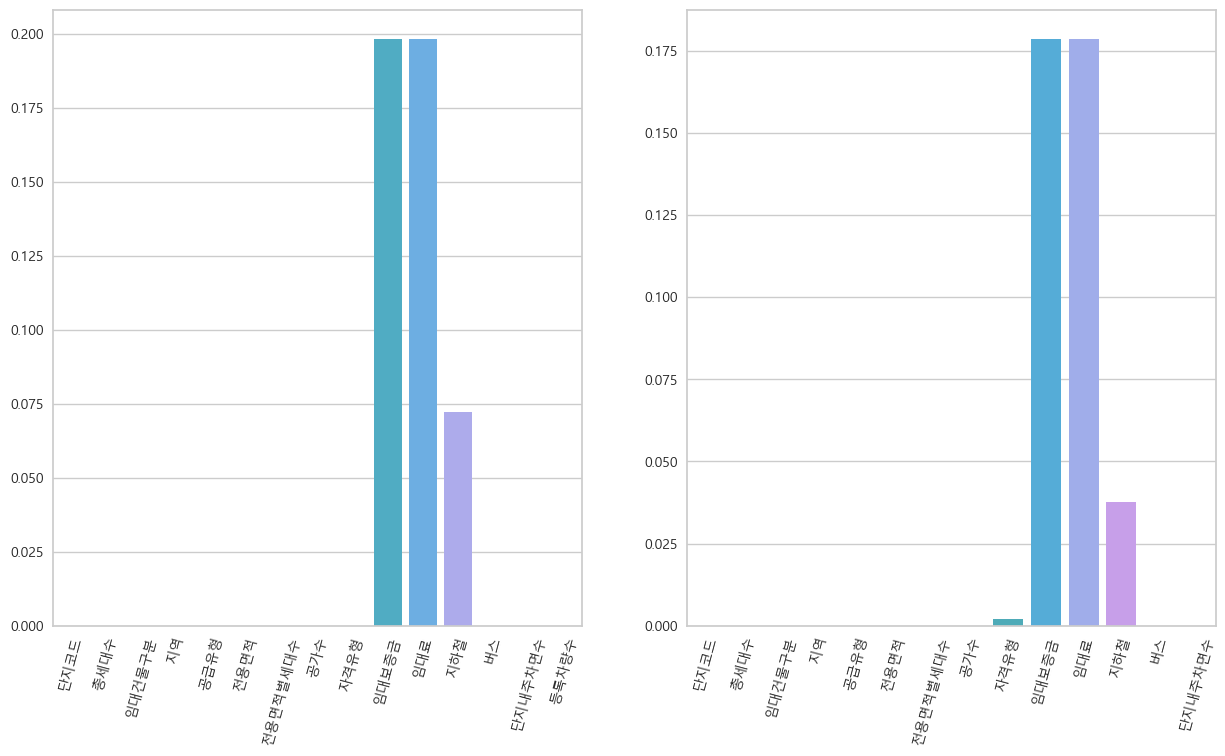

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(15,8))

sns.barplot(data = df_train.isnull(), ci=None, ax=ax[0]).set_xticklabels(df_train.isnull(), rotation=75);
sns.barplot(data = df_test.isnull(), ci=None, ax=ax[1]).set_xticklabels(df_test.isnull(), rotation=75);


- 자택 유형 / 임대 보증금/ 임대료 에 대한 결측치 처리 필요 
- train엔 도보 10분거리 내 대중교통 수에 결측치 존재

In [15]:
df_train.isnull().mean()

단지코드        0.000000
총세대수        0.000000
임대건물구분      0.000000
지역          0.000000
공급유형        0.000000
전용면적        0.000000
전용면적별세대수    0.000000
공가수         0.000000
자격유형        0.000000
임대보증금       0.198327
임대료         0.198327
지하철         0.072151
버스          0.000000
단지내주차면수     0.000000
등록차량수       0.000000
dtype: float64

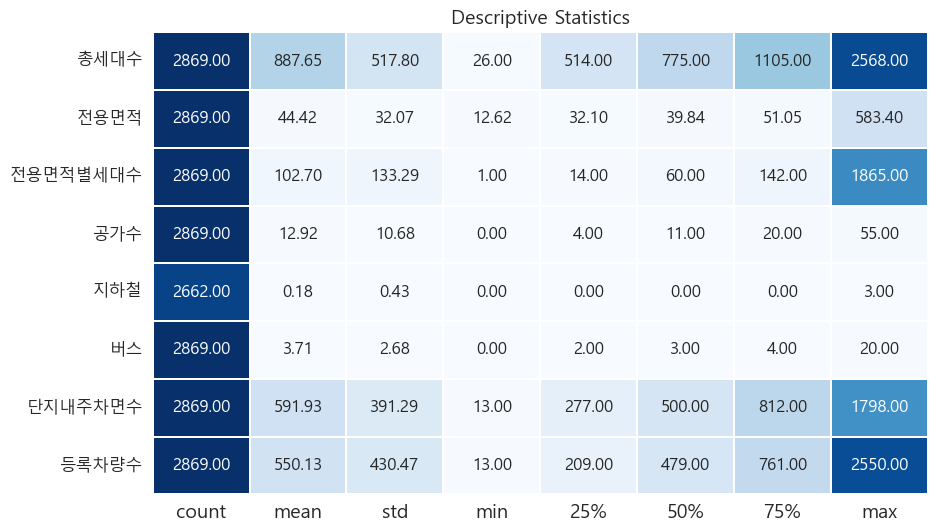

In [16]:
desc_stats(df_train)

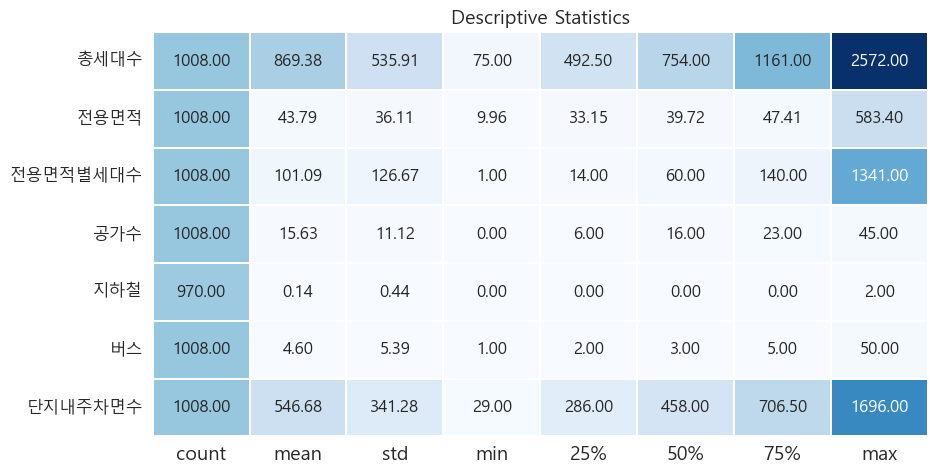

In [17]:
desc_stats(df_test)

In [18]:
obj_cols = []
for col in df_train.columns:
    if df_train[col].dtypes == 'object':
        obj_cols.append(col)

In [19]:
for col in obj_cols:
    check_train_test_column_values(df_train, df_test, col)

🐸 단지코드 Column에 대한 train_test_values_check 입니다=======================

Train-set에 있는 고유한 value 개수 : 411
Test-set에 있는 고유한 value 개수 : 147

Train/Test-set에 공통으로 포함되어 있는 value 개수 : 0
Train/Test-set에 공통으로 포함되어 있는 value : []

Train-set에만 있는 value는 총 411 개 입니다.
Test-set에만 있는 value는 총 147 개 입니다.
 
🐸 임대건물구분 Column에 대한 train_test_values_check 입니다=======================

Train-set에 있는 고유한 value 개수 : 2
Test-set에 있는 고유한 value 개수 : 2

Train/Test-set에 공통으로 포함되어 있는 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value : ['상가', '아파트']

Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []
 
🐸 지역 Column에 대한 train_test_values_check 입니다=======================

Train-set에 있는 고유한 value 개수 : 16
Test-set에 있는 고유한 value 개수 : 15

Train/Test-set에 공통으로 포함되어 있는 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value : ['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']

Train-set에만 있는 valu

- train 데이터는 2개의 테이블이 합쳐진 것으로 판단 됩니다.

- 아파트 단지 타입별로 나뉘어진 테이블과 아파트 단지의 정보가 담긴 테이블입니다.
- 또한 아파트 단지에 대한 정보를 아파트 유형과 상가 유형으로 나눌 수 있습니다.

In [20]:
train_apart = df_train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[df_train['임대건물구분'] == '아파트']
train_shop = df_train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[df_train['임대건물구분'] == '상가']
train_danji = df_train[['단지코드', '총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수']].drop_duplicates()

In [21]:
train_apart.shape, train_shop.shape, train_danji.shape

((2307, 8), (562, 6), (411, 8))

In [22]:
print(train_apart.head(3))
print()
print(train_shop.head(3))
print()
print(train_danji.head(3))

    단지코드 임대건물구분  공급유형   전용면적  전용면적별세대수 자격유형     임대보증금     임대료
0  C2515    아파트  국민임대  33.48       276    A   9216000   82940
1  C2515    아파트  국민임대  39.60        60    A  12672000  107130
2  C2515    아파트  국민임대  39.60        20    A  12672000  107130

     단지코드 임대건물구분  공급유형  전용면적  전용면적별세대수 자격유형
80  C1925     상가  임대상가  32.1         1    D
81  C1925     상가  임대상가  32.1         1    D
82  C1925     상가  임대상가  32.1         1    D

     단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수
0   C2515   545   경상남도  17.0  0.0  3.0    624.0   205.0
7   C1407  1216  대전광역시  13.0  1.0  1.0   1285.0  1064.0
18  C1945   755    경기도   6.0  1.0  3.0    734.0   730.0


In [23]:
test_apart = df_test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[df_test['임대건물구분'] == '아파트']
test_shop = df_test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[df_test['임대건물구분'] == '상가']
test_danji = df_test[['단지코드', '총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수']].drop_duplicates()

train set과 test set 의 평균과 편차가 큰 차이가 없다

In [24]:
test_apart.shape, test_shop.shape, test_danji.shape

((831, 8), (177, 6), (147, 7))

In [25]:
print(test_apart.head(3))
print()
print(test_shop.head(3))
print()
print(test_danji.head(3))

    단지코드 임대건물구분  공급유형   전용면적  전용면적별세대수 자격유형     임대보증금     임대료
0  C1072    아파트  국민임대  39.79       116    H  22830000  189840
1  C1072    아파트  국민임대  46.81        30    A  36048000  249930
2  C1072    아파트  국민임대  46.90       112    H  36048000  249930

     단지코드 임대건물구분  공급유형   전용면적  전용면적별세대수 자격유형
80  C1006     상가  임대상가  38.00         1    D
81  C1006     상가  임대상가  38.00         1    D
82  C1006     상가  임대상가  37.26         1    D

     단지코드  총세대수     지역   공가수  지하철    버스  단지내주차면수
0   C1072   754    경기도  14.0  0.0   2.0    683.0
8   C1128  1354    경기도   9.0  0.0   3.0   1216.0
17  C1456   619  부산광역시  18.0  0.0  16.0    547.0


test set의 단지는 총 150개 입니다. 이중 50/100 개로 나뉘어 평가합니다.

### Missing Values

In [26]:
df_train.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,569


임대보증금, 임대료, 지하철역, 버스정류장 에서 결측치가 있습니다.  
임대보증금, 임대료에서의 결측치는 등장하는 row가 동일해 보입니다.

In [27]:
df_test.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,2
임대보증금,180


test set에서는 자격유형에서 결측치가 조금 보입니다.
그리고 지하철역에서 결측치가 많이 보입니다.

In [28]:
print('전체 단지 수: ', df_train['단지코드'].nunique())
print('지하철 결측치 단지 수: ', df_train.loc[df_train['지하철'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', df_train.loc[df_train['지하철'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', df_train.loc[df_train['지하철'].isnull()]['지역'].unique())

전체 단지 수:  411
지하철 결측치 단지 수:  19
지하철 결측치 단지:  ['C1312' 'C1874' 'C1424' 'C2100' 'C2520' 'C1616' 'C1704' 'C2258' 'C1068'
 'C1983' 'C2216' 'C2644' 'C1005' 'C1004' 'C1875' 'C2156' 'C1175' 'C2583'
 'C1350']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시']


- 지하철 결측값은 총 20개의 단지에서 발생했습니다.
- 지하철 결측값은 충남, 대전, 경남에서만 발생하였습니다.
- 해당 지역에 지하철이 없더라도 0.0 으로 값이 채워져 있는 단지가 있습니다.
- 따라서 패턴이 없는 단순 결측치로 보입니다.
- 그러나 충남 북부나, 경남 남부 같은 경우는 지하철이 있는 도시가 있습니다. 마찬가지로 대전은 대전지하철이 있습니다. 결측치를 어떻게 채울지 고심해봐야 합니다.

In [29]:
print('전체 단지 수: ',df_test['단지코드'].nunique())
print('지하철 결측치 단지 수: ', df_test.loc[df_test['지하철'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', df_test.loc[df_test['지하철'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', df_test.loc[df_test['지하철'].isnull()]['지역'].unique())

전체 단지 수:  147
지하철 결측치 단지 수:  4
지하철 결측치 단지:  ['C1472' 'C1083' 'C2177' 'C1318']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시']


test set에서는 5개 단지에서 지하철 정보가 없습니다. 전부 충남과 대전입니다.

In [30]:
df_train.loc[df_train['버스'].isnull()]['지역'].unique()

array([], dtype=object)

- 버스 정류장 데이터가 없는 단지는 단 하나 뿐입니다.
- test set에는 없습니다.

In [31]:
df_train.loc[(df_train['임대건물구분'] != '상가') & (df_train['임대보증금'].isnull())]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0


In [32]:
df_test.loc[(df_test['임대건물구분'] != '상가') & (df_test['임대보증금'].isnull())]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0


In [33]:
print('전체 단지 수: ', df_train['단지코드'].nunique())
print('상가 보유 단지 수: ', df_train.loc[df_train['임대건물구분'] == '상가']['단지코드'].nunique())
print('상가 보유 단지: ', df_train.loc[df_train['임대건물구분'] == '상가']['단지코드'].unique())
print('상가 보유 단지 지역: ', df_train.loc[df_train['임대건물구분'] == '상가']['지역'].unique())

전체 단지 수:  411
상가 보유 단지 수:  33
상가 보유 단지:  ['C1925' 'C1874' 'C2416' 'C2621' 'C1616' 'C1704' 'C2258' 'C2038' 'C1859'
 'C1722' 'C2190' 'C1476' 'C1983' 'C2135' 'C2034' 'C1109' 'C2289' 'C2597'
 'C2310' 'C2132' 'C1439' 'C1899' 'C1056' 'C2644' 'C1206' 'C1775' 'C1790'
 'C2109' 'C1698' 'C1004' 'C1875' 'C2212' 'C2571']
상가 보유 단지 지역:  ['강원도' '충청남도' '경상남도' '대전광역시' '부산광역시' '제주특별자치도']


In [34]:
print('전체 단지 수: ', df_test['단지코드'].nunique())
print('상가 보유 단지 수: ', df_test.loc[df_test['임대건물구분'] == '상가']['단지코드'].nunique())
print('상가 보유 단지: ', df_test.loc[df_test['임대건물구분'] == '상가']['단지코드'].unique())
print('상가 보유 단지 지역: ', df_test.loc[df_test['임대건물구분'] == '상가']['지역'].unique())

전체 단지 수:  147
상가 보유 단지 수:  7
상가 보유 단지:  ['C1006' 'C2676' 'C2177' 'C2033' 'C1812' 'C2253' 'C1729']
상가 보유 단지 지역:  ['대전광역시' '부산광역시' '충청남도' '울산광역시' '강원도']


총세대수

In [35]:
df_train.loc[df_train['단지코드'] == 'C1004']['전용면적별세대수'].sum()

521

In [36]:
(df_train.groupby(['단지코드'])['전용면적별세대수'].sum() != df_train.groupby(['단지코드'])['총세대수'].max()).sum()

38

In [37]:
train_danji.set_index('단지코드').loc[(df_train.groupby(['단지코드'])['전용면적별세대수'].sum() != 
df_train.groupby(['단지코드'])['총세대수'].max())]

,총세대수,지역,공가수,지하철,버스,단지내주차면수,등록차량수
단지코드,,,,,,,
C1925,601,강원도,9.0,0.0,4.0,117.0,75.0
C1312,518,충청남도,12.0,NaN,3.0,527.0,359.0
C2013,595,경상남도,3.0,0.0,3.0,509.0,91.0
C1424,625,대전광역시,2.0,NaN,7.0,517.0,179.0
C2520,970,대전광역시,2.0,NaN,2.0,420.0,386.0
C2319,606,대전광역시,1.0,1.0,12.0,548.0,266.0
C1850,388,경상남도,0.0,0.0,4.0,226.0,254.0
C1068,806,충청남도,11.0,NaN,2.0,804.0,510.0
C2644,779,충청남도,7.0,NaN,12.0,190.0,177.0


### Feature Engineering 

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   float64
 8   자격유형      2869 non-null   object 
 9   임대보증금     2300 non-null   object 
 10  임대료       2300 non-null   object 
 11  지하철       2662 non-null   float64
 12  버스        2869 non-null   float64
 13  단지내주차면수   2869 non-null   float64
 14  등록차량수     2869 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 336.3+ KB


In [39]:
# 중복데이터 존재여부 확인 및 제거 
df_train.shape, df_train.drop_duplicates().shape # 중복 존재

((2869, 15), (2549, 15))

In [40]:
df_test.shape, df_test.drop_duplicates().shape

((1008, 14), (936, 14))

In [41]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [42]:
df_train.loc[df_train.임대보증금=='-', '임대보증금'] = np.nan
df_test.loc[df_test.임대보증금=='-', '임대보증금'] = np.nan
df_train['임대보증금'] = df_train['임대보증금'].astype(float)
df_test['임대보증금'] = df_test['임대보증금'].astype(float)

df_train.loc[df_train.임대료=='-', '임대료'] = np.nan
df_test.loc[df_test.임대료=='-', '임대료'] = np.nan

df_train['임대료'] = df_train['임대료'].astype(float)
df_test['임대료'] = df_test['임대료'].astype(float)

##### 임대료 및 임대 보증금 처리


In [43]:
df_train['임대보증금'] = df_train['임대보증금'].fillna(0)
df_train['임대료'] = df_train['임대료'].fillna(0)

df_test['임대보증금'] = df_test['임대보증금'].fillna(0)
df_test['임대료'] = df_test['임대료'].fillna(0)

In [44]:
#임대 상가의 임대료 처리 
df_train.loc[df_train['지역'] == '부산광역시', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '부산광역시']['임대료'].mean())
df_train.loc[df_train['지역'] == '대전광역시', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '대전광역시']['임대료'].mean())
df_train.loc[df_train['지역'] == '경상남도', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '경상남도']['임대료'].mean())
df_train.loc[df_train['지역'] == '충청남도', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '충청남도']['임대료'].mean())
df_train.loc[df_train['지역'] == '강원도', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '강원도']['임대료'].mean())
df_train.loc[df_train['지역'] == '제주특별자치도', '임대료'] = df_train['임대료'].fillna(df_train[df_train['지역'] == '제주특별자치도']['임대료'].mean())

#임대 상가의 임대보증금 처리 
df_train.loc[df_train['지역'] == '부산광역시', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '부산광역시']['임대보증금'].mean())
df_train.loc[df_train['지역'] == '대전광역시', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '대전광역시']['임대보증금'].mean())
df_train.loc[df_train['지역'] == '경상남도', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '경상남도']['임대보증금'].mean())
df_train.loc[df_train['지역'] == '충청남도', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '충청남도']['임대보증금'].mean())
df_train.loc[df_train['지역'] == '강원도', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '강원도']['임대보증금'].mean())
df_train.loc[df_train['지역'] == '제주특별자치도', '임대보증금'] = df_train['임대보증금'].fillna(df_train[df_train['지역'] == '제주특별자치도']['임대보증금'].mean())

In [45]:
#임대 상가의 임대료 처리  (test 특성 기준 test null 값 처리는 data leakage 여서 train의 지역 기준으로 test 처리)
df_test.loc[df_test['지역'] == '부산광역시', '임대료'] = df_test['임대료'].fillna(df_train[df_train['지역'] == '부산광역시']['임대료'].mean())
df_test.loc[df_test['지역'] == '대전광역시', '임대료'] = df_test['임대료'].fillna(df_train[df_train['지역'] == '대전광역시']['임대료'].mean())
df_test.loc[df_test['지역'] == '울산광역시', '임대료'] = df_test['임대료'].fillna(df_train[df_train['지역'] == '울산광역시']['임대료'].mean())
df_test.loc[df_test['지역'] == '충청남도', '임대료'] = df_test['임대료'].fillna(df_train[df_train['지역'] == '충청남도']['임대료'].mean())
df_test.loc[df_test['지역'] == '강원도', '임대료'] = df_test['임대료'].fillna(df_train[df_train['지역'] == '강원도']['임대료'].mean())  


#임대 상가의 임대보증금 처리 
df_test.loc[df_test['지역'] == '부산광역시', '임대보증금'] = df_test['임대보증금'].fillna(df_train[df_train['지역'] == '부산광역시']['임대보증금'].mean())
df_test.loc[df_test['지역'] == '대전광역시', '임대보증금'] = df_test['임대보증금'].fillna(df_train[df_train['지역'] == '대전광역시']['임대보증금'].mean())
df_test.loc[df_test['지역'] == '울산광역시', '임대보증금'] = df_test['임대보증금'].fillna(df_train[df_train['지역'] == '울산광역시']['임대보증금'].mean())
df_test.loc[df_test['지역'] == '충청남도', '임대보증금'] = df_test['임대보증금'].fillna(df_train[df_train['지역'] == '충청남도']['임대보증금'].mean())
df_test.loc[df_test['지역'] == '강원도', '임대보증금'] = df_test['임대보증금'].fillna(df_train[df_train['지역'] == '강원도']['임대보증금'].mean())

In [46]:
def transportation_level(x): ## 대중교통 값 조정 (원래 있던 값을 drop 하지 않았을 때 더 성능이 잘 나옴)
    result = 0
    if x <= 0 :
        result = 5
    elif 1 <= x <= 2:
        result = 4
    elif 3 <= x <= 4 :
        result = 3
    elif 5 <= x <= 6 :
        result = 2
    elif 7 <= x:
        result = 1
    return result

In [47]:
cols = ['지하철', '버스']
df_train[cols] = df_train[cols].fillna(0)
df_test[cols] = df_test[cols].fillna(0)

In [48]:
# 임대보증금과 임대료가 존재하는 경우 자격유형이 C => C로 채우면 될듯
df_test.loc[df_test.단지코드.isin(['C2253']) & df_test.자격유형.isnull(), '자격유형'] = 'C'
df_test.loc[df_test.단지코드.isin(['C2411']) & df_test.자격유형.isnull(), '자격유형'] = 'A'

df_train['자격유형'] = df_train['자격유형'].fillna(method='backfill')
df_test['자격유형'] = df_test['자격유형'].fillna(method='backfill')

In [49]:
df_train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수         411
임대건물구분       444
지역           411
공급유형         475
전용면적        1835
전용면적별세대수    2155
공가수          411
자격유형         498
임대보증금       1234
임대료         1248
지하철          411
버스           411
단지내주차면수      411
등록차량수        411
dtype: int64

- 값이 423보다 크면 하나의 단지코드에 대해 둘 이상의 항목이 존재하는 것
- 임대건물구분, 공급유형, 전용면적, 전용면적별세대수, 자격유형, 임대보증금, 임대료는 하나의 단지코드에 대해 둘 이상의 항목 존재
- 단지코드별 집계시 총세대수, 지역, 공가수, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수, 단지내주차면수, 등록차량수는 그대로 사용하고, 나머지 변수들은 각 항목들을 변수로 만들어 사용하는 것이 좋아보임

단지코드 집계
- 하나의 단지코드에 하나의 값만 존재하는 변수들 (423개)
    - 총세대수, 지역, 공가수, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수, 단지내주차면수, 등록차량수

In [50]:
unique_cols = ['총세대수', '지역', '공가수', 
               '지하철',
               '버스',
               '단지내주차면수', '등록차량수']
train_agg = df_train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = df_test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [51]:
df_train.groupby(['단지코드']).mean()

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
단지코드,,,,,,,,,,
C1000,566.0,45.218571,80.857143,10.0,1.320357e+07,121064.285714,0.0,1.0,438.0,481.0
C1004,521.0,43.480667,34.466667,3.0,6.273333e+05,13959.333333,0.0,2.0,153.0,93.0
C1005,1144.0,54.360000,381.333333,16.0,1.710767e+07,222046.666667,0.0,8.0,950.0,376.0
C1013,1308.0,46.142000,261.600000,16.0,2.492480e+07,134726.000000,0.0,6.0,1119.0,1665.0
C1014,996.0,49.232857,142.285714,5.0,2.389400e+07,160488.571429,0.0,2.0,823.0,708.0
...,...,...,...,...,...,...,...,...,...,...
C2663,772.0,41.005000,128.666667,14.0,3.025867e+07,269070.000000,0.0,3.0,700.0,652.0
C2666,1084.0,43.258333,180.666667,23.0,1.889050e+07,133145.000000,0.0,1.0,837.0,701.0
C2670,648.0,40.918000,129.600000,9.0,1.635000e+07,115188.000000,0.0,2.0,600.0,435.0


In [52]:
# 임대 건물 구분, 전용면적 별 세대수, 임대보증금
# 등과 같이 처리가 애매한 값은 각 단지 별 mean값이나 고유값 개수로 처리 

tr = df_train.groupby(['단지코드']).mean() ##같은 단지코드 안에서의 평균 값, max 값 등은 data leakage가 아닌 것으로 보임 
ts = df_test.groupby(['단지코드']).mean()

train_agg['전용면적별세대수 평균'] = tr['전용면적별세대수']
test_agg['전용면적별세대수 평균'] = ts['전용면적별세대수']

train_agg['임대보증금 평균'] = tr['임대보증금']
test_agg['임대보증금 평균'] = ts['임대보증금']

train_agg['임대료 평균'] = tr['임대료']
test_agg['임대료 평균'] = ts['임대료']

- 하나의 단지코드에 둘 이상의 값이 존재하는 변수들
    - 임대건물구분, 공급유형, 전용면적, 전용면적별세대수, 자격유형, 임대보증금, 임대료

In [53]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

- 임대건물구분: 아파트/상가
    - 주상복합인 경우 주차수요가 주거only인 경우보다 많지 않을까? => 상가 직원들도 차량 등록이 가능하면 상가 당 주차수요는 일반 가구보다 높을 수 있음
    - 상가의 전용면적별세대수는 모두 1
    - 우선 임대건물구분을 열로 올려서 단지가 주상복합인지 아닌지 구분할 수 있게 해야함
- 원핫인코딩처럼 처리

In [54]:
reshape_cat_features(data=df_train, cast_col='임대건물구분', value_col='counter').columns

Index(['임대건물구분_상가', '임대건물구분_아파트'], dtype='object')

In [55]:
reshape_cat_features(data=df_test, cast_col='임대건물구분', value_col='counter').columns

Index(['임대건물구분_상가', '임대건물구분_아파트'], dtype='object')

- 공급유형
    - 국민임대와 공공임대의 차이
    - LH공사와 SH공사에서 제공하는 국민임대는 국가 재정과 국민주택기금을 지원받아 국가, 지방자치단체, 한국토지주택공사 또는 지방공사가 건설, 공급하는 주택을 의미한다. 저렴한 임대료를 지불하고 장기(30년) 임대가 가능하다. 장기 거주는 가능하지만 해당 주거지를 매입할 수 없다는 단점이 있다.
    - 반면 공공임대는 5년 또는 10년 후 임대기간이 종료되었을 때 입주자에게 우선 분양전환혜택을 준다.

In [56]:
df_train.loc[df_train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
df_test.loc[df_test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
df_train.loc[df_train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
df_test.loc[df_test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

In [57]:
set(df_train.공급유형), set(df_test.공급유형)

({'공공임대(50년)', '공공임대(5년/10년/분납/분양)', '국민임대/장기전세', '영구임대', '임대상가', '행복주택'},
 {'공공임대(50년)', '공공임대(5년/10년/분납/분양)', '국민임대/장기전세', '영구임대', '임대상가', '행복주택'})

In [58]:
reshape_cat_features(data=df_train, cast_col='공급유형', value_col='counter').columns

Index(['공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택'],
      dtype='object')

In [59]:
reshape_cat_features(data=df_test, cast_col='공급유형', value_col='counter').columns

Index(['공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택'],
      dtype='object')

자격 유형 

- 변수생성 컨셉: 특정자격 유형이 많으면 그 단지는 등록차량수가 적을 것이다.
- 예를들어, 소득수준이 낮은 자격유형의 세대가 많으면 주차수요가 적을 가능성이 높을 것으로 예상해볼 수 있다.
- 문제는 특성이 비슷한 항목끼리 묶어야 의미가 있을 것 같은데, 비식별화 되어 있어서 각 코드값이 무엇인지 정확히 알 수 없다는 것임
- 단지코드별로 자격유형별 세대수를 알 수 있으면 좋을 것 같지만 이 데이터에서는 파악 불가능
- 자격유형별 소득수준을 간접적으로 파악하기 위해 자격유형별 임대보증금의 평균, 임대료의 평균을 변수로 사용해 볼 수 있을 것 같음

🐸 자격유형 Column에 대한 train_test_values_check 입니다=======================   
   
Train-set에 있는 고유한 value 개수 : 15   
Test-set에 있는 고유한 value 개수 : 13   
   
================================================================================    
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 12    
Train/Test-set에 공통으로 포함되어 있는 value : ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']    
    
Train-set에만 있는 value는 총 3 개 입니다.   
Train-set에만 있는 value는 : ['B', 'F', 'O']   
Test-set에만 있는 value는 총 1 개 입니다.  
Test-set에만 있는 value는 : [nan]  

[공공 임대주택 공급대상](https://www.myhome.go.kr/hws/portal/cont/selectContRentalView.do#guide=RH101)

    - 영구임대: 생계급여 또는 의료급여 수급자 등[소득 1분위] - 1
    - 국민임대: 무주택세대구성원[소득 2~4분위] - 3
    - 장기전세: 무주택세대구성원[소득 3~4분위] - 2
    - 공공임대(5년/10년/분납): 무주택세대구성원[소득 3~5분위] - 3
    - 행복주택: 무주택세대구성원/무주택자[소득 2~5분위] - 4
- 이렇게 나누면 13개 항목인데 자격유형의 항목수는 15개

In [60]:
# 자격유형 B는 공급유형이 모두 국민임대/장기전세, 공급유형이 국민임대/장기전세 일때 자격유형이 어떤게 있는지 보는게 좋을 듯
df_train.loc[df_train.자격유형=='B', ['임대건물구분', '공급유형']].drop_duplicates()

,임대건물구분,공급유형
18,아파트,국민임대/장기전세


In [61]:
df_train.loc[df_train.공급유형.isin(['국민임대/장기전세']), '자격유형'].value_counts()

A    1487
H     154
E      34
B      18
G       9
Name: 자격유형, dtype: int64

- 대상자
```
(일반)해당지역 거주 무주택세대구성원
(특별/우선)3자녀 이상 가구
(특별/우선)국가유공자
(특별/우선)영구임대 입주자
(특별/우선)비닐간이공작물 거주자
(특별/우선)신혼부부(혼인기간 5년이내)
(특별/우선)사업지구 철거민
(특별/우선)기타 공급대상(고령자, 노부모부양자, 장애인, 파독근로자 등)
건수가 가장 많은 A는 해당지역 거주 무주택세대구성원으로 예상됨
```

In [62]:
# 다른 공급유형별 자격유형
df_train.loc[df_train.공급유형.isin(['영구임대']), '자격유형'].value_counts()

C    92
I    49
E     3
F     3
A     2
Name: 자격유형, dtype: int64

대상자
```
(일반)생계급여 또는 의료급여 수급자
(일반)국가유공자
(특별/우선)수급자 선정기준의 소득인정액 이하인 국가유공자
(특별/우선)귀환국군포로
(특별/우선)수급자 신혼부부
```

In [63]:
df_train.loc[df_train.공급유형.isin(['공공임대(5년/10년/분납/분양)']), '자격유형'].value_counts()

A    183
D      7
Name: 자격유형, dtype: int64

공공임대(5년/10년/분납/분양) 대상자
```
(일반)해당지역 거주무주택세대구성원
(특별/우선)다자녀 특별
(특별/우선)신혼부부 특별
(특별/우선)생애최초 특별
(특별/우선)노부모부양 특별
(특별/우선)국가유공자 특별
(특별/우선)기타 특별(장애인, 철거민 등)
A는 '(일반)해당지역 거주무주택세대구성원'으로 추정됨
```

In [64]:
df_train.loc[df_train.공급유형.isin(['행복주택']), '자격유형'].value_counts()

J    94
K    33
L    33
N    29
M     2
O     1
Name: 자격유형, dtype: int64

행복주택 대상자

대학생(취준생 포함), 사회초년생(재취준생 포함), 신혼부부(예비신혼부부, 대학생, 취준생 신혼부부 포함), 고령자, 주거급여수급자, 산업단지 근로자

In [65]:
df_train.loc[df_train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '공급유형'].value_counts()

행복주택    192
Name: 공급유형, dtype: int64

'J', 'L', 'K', 'N', 'M', 'O' 는 공급유형이 행복주택인 경우에서만 나타남   
이것만 따로 묶어 전처리 할 예정

In [66]:
df_train.loc[df_train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
df_test.loc[df_test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

자격유형별 공급유형 value_counts()

In [67]:
df_train.loc[df_train.자격유형.isin(['A']), '공급유형'].value_counts()

국민임대/장기전세             1487
공공임대(5년/10년/분납/분양)     183
공공임대(50년)               31
영구임대                     2
Name: 공급유형, dtype: int64

In [68]:
df_train.loc[df_train.자격유형.isin(['C']), '공급유형'].value_counts()

영구임대    92
Name: 공급유형, dtype: int64

In [69]:
df_train.loc[df_train.자격유형.isin(['I']), '공급유형'].value_counts()

영구임대    49
Name: 공급유형, dtype: int64

In [70]:
df_train.loc[df_train.자격유형.isin(['E']), '공급유형'].value_counts()

국민임대/장기전세    34
영구임대          3
Name: 공급유형, dtype: int64

In [71]:
df_train.loc[df_train.자격유형.isin(['B']), '공급유형'].value_counts()

국민임대/장기전세    18
Name: 공급유형, dtype: int64

In [72]:
df_train.loc[df_train.자격유형.isin(['G']), '공급유형'].value_counts()

국민임대/장기전세    9
Name: 공급유형, dtype: int64

In [73]:
df_train.loc[df_train.자격유형.isin(['F']), '공급유형'].value_counts()

영구임대    3
Name: 공급유형, dtype: int64

- 'H', 'B', 'E', 'G' 는 국민임대/장기전세 공급대상(E는 영구임대인 경우도 있긴 하지만 국민임대/장기전세인 경우가 압도적이므로 대체)
- 'C', 'I', 'F', 'G' 는 영구임대 공급대상으로 묶어 보겠음

In [74]:
df_train.loc[df_train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
df_test.loc[df_test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

df_train.loc[df_train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
df_test.loc[df_test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

In [75]:
df_train.자격유형.value_counts()

A                 1703
D                  292
국민임대/장기전세_공급대상     218
행복주택_공급대상          192
영구임대_공급대상          144
Name: 자격유형, dtype: int64

In [76]:
reshape_cat_features(data=df_train, cast_col='자격유형', value_col='counter').columns

Index(['자격유형_A', '자격유형_D', '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상',
       '자격유형_행복주택_공급대상'],
      dtype='object')

In [77]:
reshape_cat_features(data=df_test, cast_col='자격유형', value_col='counter').columns

Index(['자격유형_A', '자격유형_D', '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상',
       '자격유형_행복주택_공급대상'],
      dtype='object')

##### 단지코드, 임대건물유형, 공급유형 , 자격유형, Feature Engineering 적용 
- [1등 코드 참고](https://dacon.io/competitions/official/235745/codeshare/3015?page=1&dtype=recent)

In [78]:
train_agg = pd.concat([train_agg,
                       reshape_cat_features(data=df_train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=df_train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=df_train, cast_col='자격유형', value_col='counter')], axis=1)

test_agg = pd.concat([test_agg,
                       reshape_cat_features(data=df_test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=df_test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=df_test, cast_col='자격유형', value_col='counter')], axis=1)

In [79]:
train_agg = train_agg.reset_index()

In [80]:
test_agg = test_agg.reset_index()

target변수 = 등록차량수

Merge Age_gender dataset

In [81]:
minors = ['10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)']
df_info['미성년자'] = df_info[minors].sum(axis=1)

In [82]:
train_agg = train_agg.merge(df_info, left_on= ["지역"], right_on= ["지역"], how='left')
test_agg = test_agg.merge(df_info, left_on= ["지역"], right_on= ["지역"], how='left')

In [83]:
train_agg.shape, train_agg.drop_duplicates().shape

((411, 47), (411, 47))

In [84]:
test_agg.shape, test_agg.drop_duplicates().shape

((147, 46), (147, 46))

In [85]:
train_agg['대중교통현황'] = train_agg[cols].sum(axis=1)
test_agg['대중교통현황'] = test_agg[cols].sum(axis=1)

In [86]:
train_agg['주차면수/총세대'] = train_agg['단지내주차면수'] / train_agg['총세대수']
test_agg['주차면수/총세대'] = test_agg['단지내주차면수'] / test_agg['총세대수']


train_agg['단지내주차면수/100'] = train_agg['단지내주차면수']/100
test_agg['단지내주차면수/100'] = test_agg['단지내주차면수']/100


In [87]:
train_agg.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수',
       '전용면적별세대수 평균', '임대보증금 평균', '임대료 평균', '임대건물구분_상가', '임대건물구분_아파트',
       '공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택', '자격유형_A', '자격유형_D',
       '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상', '자격유형_행복주택_공급대상', '10대미만(여자)',
       '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)',
       '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)',
       '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)',
       '90대(남자)', '100대(여자)', '100대(남자)', '미성년자', '대중교통현황', '주차면수/총세대',
       '단지내주차면수/100'],
      dtype='object')

##### Log

In [88]:
def log_transform(df,col):
    for i in col:
        col_name = f'{i}_log'
        df[col_name] =  np.log1p(df[i])
    return df


train_agg = log_transform(train_agg,['총세대수','단지내주차면수','전용면적별세대수 평균','임대보증금 평균']) 
test_agg = log_transform(test_agg,['총세대수','단지내주차면수','전용면적별세대수 평균','임대보증금 평균']) 

##### corr

#### 주차수요 예측 방법 
- 아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 정확한 ②장래주차수요의 산정을 필요로 함
- 현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며, ‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있음
- 이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없음

In [89]:
train_agg['주차면수대비등록확률'] = train_agg['등록차량수'] / train_agg['단지내주차면수']
train_agg = train_agg.drop(columns=['등록차량수'])

In [90]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 410
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   단지코드                     411 non-null    object 
 1   총세대수                     411 non-null    int64  
 2   지역                       411 non-null    object 
 3   공가수                      411 non-null    float64
 4   지하철                      411 non-null    float64
 5   버스                       411 non-null    float64
 6   단지내주차면수                  411 non-null    float64
 7   전용면적별세대수 평균              411 non-null    float64
 8   임대보증금 평균                 411 non-null    float64
 9   임대료 평균                   411 non-null    float64
 10  임대건물구분_상가                411 non-null    float64
 11  임대건물구분_아파트               411 non-null    float64
 12  공급유형_공공임대(50년)           411 non-null    float64
 13  공급유형_공공임대(5년/10년/분납/분양)  411 non-null    float64
 14  공급유형_국민임대/장기전세           4

### Modeling

In [91]:
# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [92]:
ignore_features=['단지코드', '10대미만(여자)','10대미만(남자)', '90대(여자)',
       '90대(남자)', '100대(여자)', '100대(남자)','단지내주차면수','지역','주차면수대비등록확률']

label = '주차면수대비등록확률'
feature = list(set(train_agg.columns.tolist()) - set(ignore_features))


train_df = train_agg[feature+[label]] 
test_df = test_agg[feature]
test_df[label] = 0.0

train_df.shape, test_df.shape

((411, 45), (147, 45))

In [93]:
train_X = train_df.drop(columns = label)
train_y = train_df[label]

test_X = test_df.drop(columns=label)
test_y = test_df[label]


train_X.shape, test_X.shape, train_y.shape, test_y.shape

((411, 44), (147, 44), (411,), (147,))

In [94]:
# y Transform
IQR = np.quantile(train_y, 0.75) - np.quantile(train_y, 0.25)
min_value = np.quantile(train_y, 0.25) - IQR #* 1.5
max_value = np.quantile(train_y, 0.75) + IQR #* 1.5
train_y = train_y.apply(lambda x : x if x>min_value else min_value)
train_y = train_y.apply(lambda x : x if x<max_value else max_value)

train_y.shape

(411,)

In [95]:
from sklearn.preprocessing import StandardScaler, RobustScaler
rb = RobustScaler()
train_X = rb.fit_transform(train_X)
test_X = rb.transform(test_X)

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cpu')


train_X = torch.FloatTensor(train_X) # nd.array를 tensor 형식으로 바꿔준다. 
test_X = torch.FloatTensor(test_X)
train_y = torch.FloatTensor(train_y).reshape(-1,1) # flatten 

In [97]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

(torch.Size([411, 44]), torch.Size([147, 44]), torch.Size([411, 1]), (147,))

In [98]:
from pytorch_tabnet.tab_model import TabNetClassifier

https://slowsteadystat.tistory.com/23

In [99]:
linear1 = torch.nn.Linear(train_X.shape[1], 512, bias=True)
linear3 = torch.nn.Linear(512, 256, bias=True)
linear4 = torch.nn.Linear(256, 128, bias=True)
linear5 = torch.nn.Linear(128, 64, bias=True)
linear6 = torch.nn.Linear(64, 32, bias=True)
linear7 = torch.nn.Linear(32, 10, bias=True)
linear8 = torch.nn.Linear(10, 1, bias=True)

relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.1)

In [100]:
model = torch.nn.Sequential(linear1,relu,
                            linear3,relu,
                            linear4, relu,
                            linear5, relu,
                            dropout,
                            linear6, relu,
                            linear7, relu,
                            linear8).to(device)

In [109]:
!pip install torchsummaryX
from torchsummaryX import summary

In [111]:
summary(model, torch.zeros((44)))

      Kernel Shape Output Shape    Params Mult-Adds
Layer                                              
0_0      [44, 512]        [512]    23.04k   22.528k
1_1              -        [512]         -         -
2_2     [512, 256]        [256]  131.328k  131.072k
3_1              -        [256]         -         -
4_4     [256, 128]        [128]   32.896k   32.768k
5_1              -        [128]         -         -
6_6      [128, 64]         [64]    8.256k    8.192k
7_1              -         [64]         -         -
8_8              -         [64]         -         -
9_9       [64, 32]         [32]     2.08k    2.048k
10_1             -         [32]         -         -
11_11     [32, 10]         [10]     330.0     320.0
12_1             -         [10]         -         -
13_13      [10, 1]          [1]      11.0      10.0
----------------------------------------------------
                        Totals
Total params          197.941k
Trainable params      197.941k
Non-trainable params  

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[44, 512]",[512],23040.0,22528.0
1_1,-,[512],NaN,NaN
2_2,"[512, 256]",[256],131328.0,131072.0
3_1,-,[256],NaN,NaN
4_4,"[256, 128]",[128],32896.0,32768.0
5_1,-,[128],NaN,NaN
6_6,"[128, 64]",[64],8256.0,8192.0
7_1,-,[64],NaN,NaN
8_8,-,[64],NaN,NaN


In [101]:
# nn 패키지를 사용하여 모델과 손실 함수를 정의합니다.
loss_fn = torch.nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear3.weight)
torch.nn.init.xavier_normal_(linear4.weight)
torch.nn.init.xavier_normal_(linear5.weight)
torch.nn.init.xavier_normal_(linear6.weight)
torch.nn.init.xavier_normal_(linear7.weight)
torch.nn.init.xavier_normal_(linear8.weight)

Parameter containing:
tensor([[ 0.1236, -0.1419, -0.0566, -0.4679, -0.2805,  0.5435, -0.6556,  0.5466,
          0.3327,  0.6592]], requires_grad=True)

In [102]:
# 모델 학습
for epoch in range(500):
    
    # grad 초기화
    optimizer.zero_grad()
    
    # H(x)
    output = model(train_X)
    
    # cost 계산
    cost = loss_fn(output, train_y)
    
    # cost로 H(x) 개선
    cost.backward()
    optimizer.step()

    # epoch 50마다 cost, error 찍기
    if epoch % 50 == 0:
        # mape
        err = cost 
        # err = mean_squared_error(y_train, output.int())
        print(f"Epoch: {epoch} Cost: {cost:.4f} Error: {err.item():.4f}")

Epoch: 0 Cost: 1.1136 Error: 1.1136
Epoch: 50 Cost: 0.1610 Error: 0.1610
Epoch: 100 Cost: 0.1126 Error: 0.1126
Epoch: 150 Cost: 0.0858 Error: 0.0858
Epoch: 200 Cost: 0.0740 Error: 0.0740
Epoch: 250 Cost: 0.0573 Error: 0.0573
Epoch: 300 Cost: 0.0527 Error: 0.0527
Epoch: 350 Cost: 0.0467 Error: 0.0467
Epoch: 400 Cost: 0.0424 Error: 0.0424
Epoch: 450 Cost: 0.0444 Error: 0.0444


In [103]:
pred = model(test_X)
pred = pred.detach().numpy().flatten()

In [104]:
pred 

array([1.0997505 , 0.98042405, 1.0881143 , 0.8601647 , 0.9354682 ,
       1.1149341 , 0.80059725, 1.1731179 , 0.64462376, 1.1015644 ,
       0.8409691 , 0.39587054, 1.1003337 , 0.83327395, 0.8258294 ,
       0.75797707, 1.1505268 , 1.0601261 , 0.73969305, 0.809045  ,
       0.47300622, 0.6694864 , 0.74185467, 0.62383544, 0.79342055,
       0.511088  , 0.81643105, 0.79937625, 0.9333062 , 0.8021945 ,
       0.7197124 , 0.75493914, 0.9953315 , 0.92751074, 1.1293244 ,
       1.0373139 , 1.096297  , 0.98770106, 0.8236437 , 1.074353  ,
       0.899138  , 1.3911285 , 1.2411876 , 1.3155541 , 2.2281258 ,
       1.2084781 , 0.9160857 , 1.0658159 , 1.1592596 , 0.97428775,
       0.8247066 , 0.91644585, 0.8572831 , 1.0771368 , 0.9238882 ,
       1.2567707 , 1.1214542 , 0.85289395, 0.89587104, 0.7878412 ,
       0.9699985 , 1.1651886 , 1.0410075 , 1.4188198 , 1.1120691 ,
       1.0629803 , 0.8240334 , 0.71157   , 0.8771015 , 0.71947896,
       0.94907916, 1.1220381 , 1.3054307 , 1.2087643 , 0.86373

In [105]:
test_agg['등록차량수'] = pred * (test_agg['단지내주차면수/100']*100)

In [106]:
import pandas as pd ; pd.options.display.max_rows = 150

df_submission = test_agg[['단지코드', '등록차량수']].rename(columns={'단지코드':'code', '등록차량수':'num'})
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
df_submission = pd.concat([df_submission, error]).reset_index(drop=True)

In [107]:
df_submission

,code,num
0,C1072,751.129604
1,C1128,1192.195641
2,C1456,595.198501
3,C1840,467.069433
4,C1332,1040.240635
5,C1563,1890.928211
6,C1794,879.055781
7,C1640,551.365402
8,C1377,247.535522
9,C2072,308.438034


In [108]:
import os

version = 0;
while os.path.isfile('DNN_v'+str(version)+'.csv'):
      version+=1
df_submission.to_csv('DNN_v'+str(version)+'.csv',index=False)

- 기존 프로잭트 public : 100..8967 / private : 104.6572
- DNN_0 적용 결과 public : 111.5254 / private : 123.0716
- DNN_1 (Layer unit 512 -> 256) 111.3268567457 / 151.9543140193 -> 과적합 예상..
